<a href="https://colab.research.google.com/github/najmasya/DAA_Kelompok3_KelasA/blob/main/run.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# DAA Experiment Harness
**Tujuan**: kerangka eksperimen untuk membandingkan *Algoritma Dynamic Programming* vs *Algoritma Greedy*.

In [17]:
!nvdia-smi

/bin/bash: line 1: nvdia-smi: command not found


In [18]:
import time
import tracemalloc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Implementasi Algoritma (ISI)

In [19]:
# 1. GREEDY BY PROFIT (nilai tertinggi)
def greedy_profit_unbounded(weights, values, W):
    n = len(weights)
    idx = sorted(range(n), key=lambda i: values[i], reverse=True)

    chosen = []
    total_w = 0
    total_v = 0

    for i in idx:
        while total_w + weights[i] <= W:
            chosen.append(i)
            total_w += weights[i]
            total_v += values[i]

    return total_v, total_w, chosen

# 2. GREEDY BY DENSITY (nilai/berat)
def greedy_density_unbounded(weights, values, W):
    n = len(weights)
    idx = sorted(range(n), key=lambda i: values[i]/weights[i], reverse=True)

    chosen = []
    total_w = 0
    total_v = 0

    for i in idx:
        while total_w + weights[i] <= W:
            chosen.append(i)
            total_w += weights[i]
            total_v += values[i]

    return total_v, total_w, chosen

# 3. DYNAMIC PROGRAMMING — UNBOUNDED KNAPSACK
def dp_unbounded(weights, values, W):
    n = len(weights)

    dp = [0] * (W + 1)
    choice = [-1] * (W + 1)

    for w in range(W + 1):
        for i in range(n):
            if weights[i] <= w:
                if dp[w - weights[i]] + values[i] > dp[w]:
                    dp[w] = dp[w - weights[i]] + values[i]
                    choice[w] = i

    # Rekonstruksi solusi dari tabel choice
    w = W
    chosen = []
    while w > 0 and choice[w] != -1:
        i = choice[w]
        chosen.append(i)
        w -= weights[i]

    total_w = sum(weights[i] for i in chosen)
    return dp[W], total_w, chosen

## Pembangkit/Loader Instance

In [20]:
df = pd.read_csv(('Data_Anteraja.csv'), sep=';')

variants = {}

date_columns = {
    "Varian-1 (14 Feb)": ("Berat 14 Feb", "Harga 14 Feb"),
    "Varian-2 (15 Feb)": ("Berat 15 Feb", "Harga 15 Feb"),
    "Varian-3 (16 Feb)": ("Berat 16 Feb", "Harga 16 Feb")
}

# Loop untuk setiap varian dan ekstrak data weights dan values
for variant_name, (weight_col, value_col) in date_columns.items():
    weights = df[weight_col].tolist()
    values = df[value_col].tolist()
    variants[variant_name] = (weights, values)

In [21]:
df.head()

,ID Item,Berat 14 Feb,Harga 14 Feb,Berat 15 Feb,Harga 15 Feb,Berat 16 Feb,Harga 16 Feb
0,1,1,16,1,16,1,16
1,2,2,32,1,12,1,16
2,3,1,26,1,16,1,16
3,4,1,16,2,32,1,18
4,5,3,36,4,48,1,22


## Evaluator & Timing

In [22]:
def run_with_memory(func, *args):
    tracemalloc.start()
    start = time.perf_counter()

    result = func(*args)

    end = time.perf_counter()
    _, peak = tracemalloc.get_traced_memory()
    tracemalloc.stop()

    return result, (end - start) * 1000, peak / 1024  # (hasil, waktu dalam ms, memori puncak dalam KB)

def run_algorithm(algorithm, weights, values, W):
    if algorithm == "greedy_profit":
        result, time_ms, memory_kb = run_with_memory(greedy_profit_unbounded, weights, values, W)
    elif algorithm == "greedy_density":
        result, time_ms, memory_kb = run_with_memory(greedy_density_unbounded, weights, values, W)
    elif algorithm == "dp":
        result, time_ms, memory_kb = run_with_memory(dp_unbounded, weights, values, W)
    else:
        raise ValueError(f"Algoritma {algorithm} tidak dikenali")

    value, weight, items = result
    return {
        'value': value,
        'weight': weight,
        'items': items,
        'time_ms': time_ms,
        'memory_kb': memory_kb
    }

def calculate_gap(greedy_value, optimal_value):
    if optimal_value > 0:
        return ((optimal_value - greedy_value) / optimal_value) * 100
    return 0.0

## Eksekusi Eksperimen (atur parameter)

In [23]:
def run_experiment_fixed_W(repeats, W):
    print("=" * 80)
    print(f"EKSPERIMEN KNAPSACK UNBOUNDED (W = {W})")
    print("=" * 80)
    all_results = []
    for variant_name, (weights, values) in variants.items():
        print(f"\n{'='*60}")
        print(f"VARIAN: {variant_name}")
        print(f"{'='*60}")
        dp_result = run_algorithm("dp", weights, values, W)
        optimal_value = dp_result['value']
        print(f"Nilai Optimal (DP): {optimal_value} dengan item: {dp_result['items']}")

        for r in range(repeats):
            for algo_name in ["greedy_profit", "greedy_density", "dp"]:
                result = run_algorithm(algo_name, weights, values, W)
                gap = 0.0
                if algo_name != "dp":
                    gap = calculate_gap(result['value'], optimal_value)
                method_map = {'greedy_profit': 'Greedy-Profit', 'greedy_density': 'Greedy-Density', 'dp': 'DP-Optimal'}

                all_results.append({
                    'variant': variant_name, 'repeat': r, 'method': method_map[algo_name],
                    'value': result['value'], 'weight': result['weight'], 'time_ms': result['time_ms'],
                    'memory_kb': result['memory_kb'], 'gap_percent': gap
                })

            if r == 0:
                print(f"  Hasil (Repeat 1):")
                for method_name in ['Greedy-Profit', 'Greedy-Density', 'DP-Optimal']:
                    method_data = [res for res in all_results if res['variant'] == variant_name and res['repeat'] == 0 and res['method'] == method_name][0]
                    print(f"    {method_name:<15}: Value={method_data['value']}, "
                          f"Weight={method_data['weight']}, Time={method_data['time_ms']:.3f}ms, "
                          f"Gap={method_data['gap_percent']:.2f}%")
    return pd.DataFrame(all_results)

def summary(df):
    df_summary = (
        df.groupby(["method", "variant"])
        .agg(
            time_ms_mean=("time_ms", "mean"),
            time_ms_sd=("time_ms", "std"),
            memory_kb_mean=("memory_kb", "mean"),
            memory_kb_sd=("memory_kb", "std"),
            gap_mean=("gap_percent", "mean"),
            value=("value", "first")
        )
        .reset_index()
        .sort_values(["variant", "method"])
    )
    return df_summary

In [24]:
# Atur Parameter Eksperimen
Kapasitas = 10
Repeats = 5

df_results = run_experiment_fixed_W(repeats=Repeats, W=Kapasitas)

df_summary = summary(df_results)
print("\n" + "=" * 80)
print("RINGKASAN EKSPERIMEN")
print("=" * 80)
print(df_summary)


EKSPERIMEN KNAPSACK UNBOUNDED (W = 10)

VARIAN: Varian-1 (14 Feb)
Nilai Optimal (DP): 360 dengan item: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
  Hasil (Repeat 1):
    Greedy-Profit  : Value=200, Weight=10, Time=0.037ms, Gap=44.44%
    Greedy-Density : Value=360, Weight=10, Time=0.103ms, Gap=0.00%
    DP-Optimal     : Value=360, Weight=10, Time=0.308ms, Gap=0.00%

VARIAN: Varian-2 (15 Feb)
Nilai Optimal (DP): 320 dengan item: [21, 21, 21, 21, 21, 21, 21, 21, 21, 21]
  Hasil (Repeat 1):
    Greedy-Profit  : Value=120, Weight=10, Time=0.188ms, Gap=62.50%
    Greedy-Density : Value=320, Weight=10, Time=0.054ms, Gap=0.00%
    DP-Optimal     : Value=320, Weight=10, Time=0.274ms, Gap=0.00%

VARIAN: Varian-3 (16 Feb)
Nilai Optimal (DP): 320 dengan item: [26, 26, 26, 26, 26, 26, 26, 26, 26, 26]
  Hasil (Repeat 1):
    Greedy-Profit  : Value=180, Weight=10, Time=0.022ms, Gap=43.75%
    Greedy-Density : Value=320, Weight=10, Time=0.047ms, Gap=0.00%
    DP-Optimal     : Value=320, Weight=10, Time

In [25]:
df_results

,variant,repeat,method,value,weight,time_ms,memory_kb,gap_percent
0,Varian-1 (14 Feb),0,Greedy-Profit,200,10,0.037092,0.546875,44.444444
1,Varian-1 (14 Feb),0,Greedy-Density,360,10,0.102908,1.289062,0.000000
2,Varian-1 (14 Feb),0,DP-Optimal,360,10,0.307744,0.835938,0.000000
3,Varian-1 (14 Feb),1,Greedy-Profit,200,10,0.028637,0.546875,44.444444
4,Varian-1 (14 Feb),1,Greedy-Density,360,10,0.050685,0.773438,0.000000
5,Varian-1 (14 Feb),1,DP-Optimal,360,10,0.319842,0.835938,0.000000
6,Varian-1 (14 Feb),2,Greedy-Profit,200,10,0.025526,0.546875,44.444444
7,Varian-1 (14 Feb),2,Greedy-Density,360,10,0.055880,0.773438,0.000000
8,Varian-1 (14 Feb),2,DP-Optimal,360,10,0.275823,0.835938,0.000000
9,Varian-1 (14 Feb),3,Greedy-Profit,200,10,0.024210,0.546875,44.444444


In [26]:
df_summary

,method,variant,time_ms_mean,time_ms_sd,memory_kb_mean,memory_kb_sd,gap_mean,value
0,DP-Optimal,Varian-1 (14 Feb),0.366295,0.151271,0.835938,0.000000,0.000000,360
3,Greedy-Density,Varian-1 (14 Feb),0.061109,0.023587,0.876563,0.230595,0.000000,360
6,Greedy-Profit,Varian-1 (14 Feb),0.028075,0.005317,0.546875,0.000000,44.444444,200
1,DP-Optimal,Varian-2 (15 Feb),0.235395,0.026851,0.804688,0.000000,0.000000,320
4,Greedy-Density,Varian-2 (15 Feb),0.052316,0.011821,0.773438,0.000000,0.000000,320
7,Greedy-Profit,Varian-2 (15 Feb),0.059526,0.071989,0.546875,0.000000,62.500000,120
2,DP-Optimal,Varian-3 (16 Feb),0.318822,0.257918,0.804688,0.000000,0.000000,320
5,Greedy-Density,Varian-3 (16 Feb),0.041943,0.003479,0.773438,0.000000,0.000000,320
8,Greedy-Profit,Varian-3 (16 Feb),0.023180,0.002513,0.546875,0.000000,43.750000,180


## Plot & Tabel

In [27]:
def visualize_time_vs_variant(df):
    summary = (
        df.groupby(["method", "variant"])["time_ms"]
        .mean()
        .reset_index()
    )

    plt.figure(figsize=(12, 7))

    for method in summary["method"].unique():
        data_m = summary[summary["method"] == method]
        plt.plot(data_m["variant"], data_m["time_ms"], marker="o", label=method)

    plt.xlabel("Data Variant")
    plt.ylabel("Mean Time (ms)")
    plt.title("Mean Time across Different Data Variants (W=10)")
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=15, ha='right')
    plt.tight_layout()
    plt.show()

def visualize_time_boxplot_per_algorithm(df):
    plt.figure(figsize=(10, 7))

    methods = sorted(df["method"].unique())
    data = [df[df["method"] == m]["time_ms"] for m in methods]

    plt.boxplot(data, labels=methods)

    plt.xlabel("Algorithm")
    plt.ylabel("Execution Time (ms)")
    plt.title("Distribution of Mean Time for Each Algorithm (W=10)")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

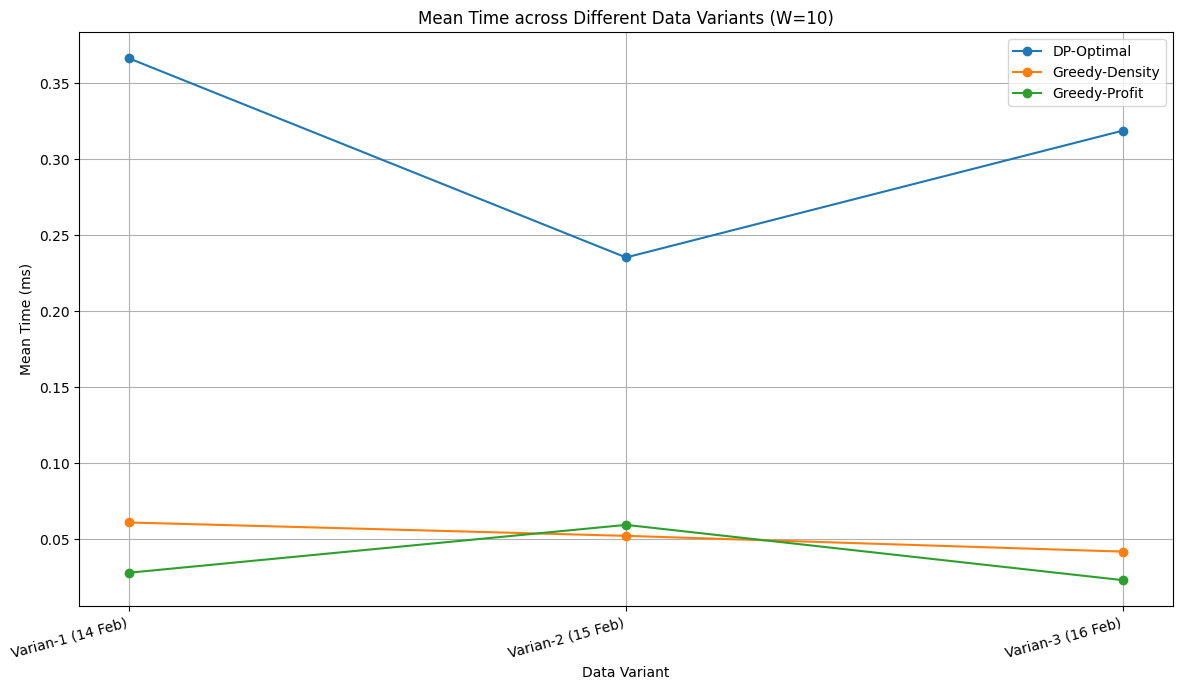

/tmp/ipython-input-1410588009.py:29: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=methods)


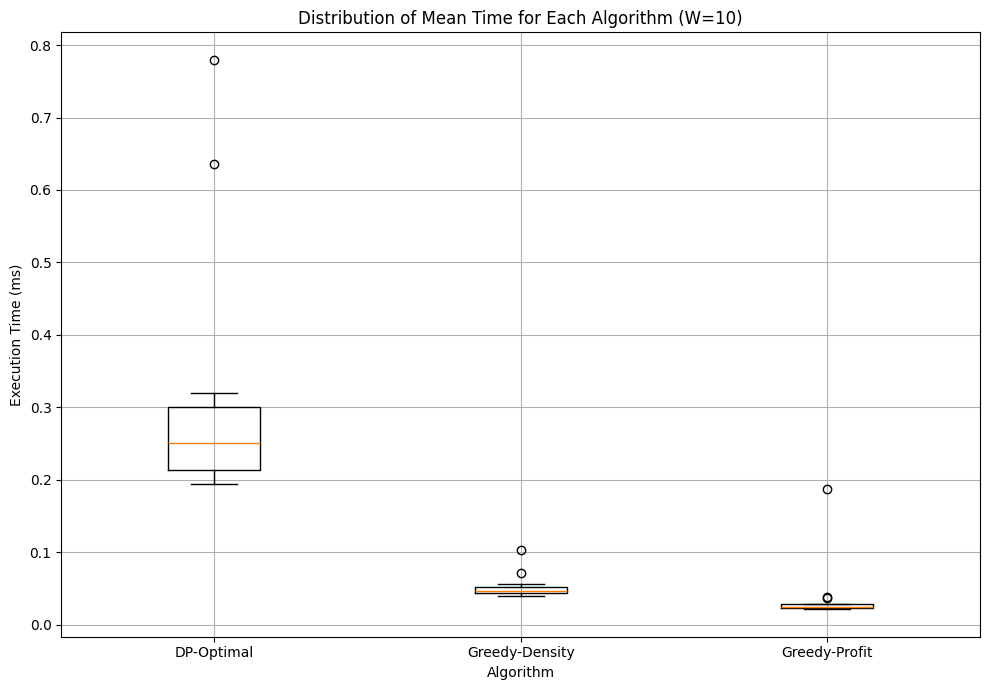

In [28]:
visualize_time_vs_variant(df_results)
visualize_time_boxplot_per_algorithm(df_results)

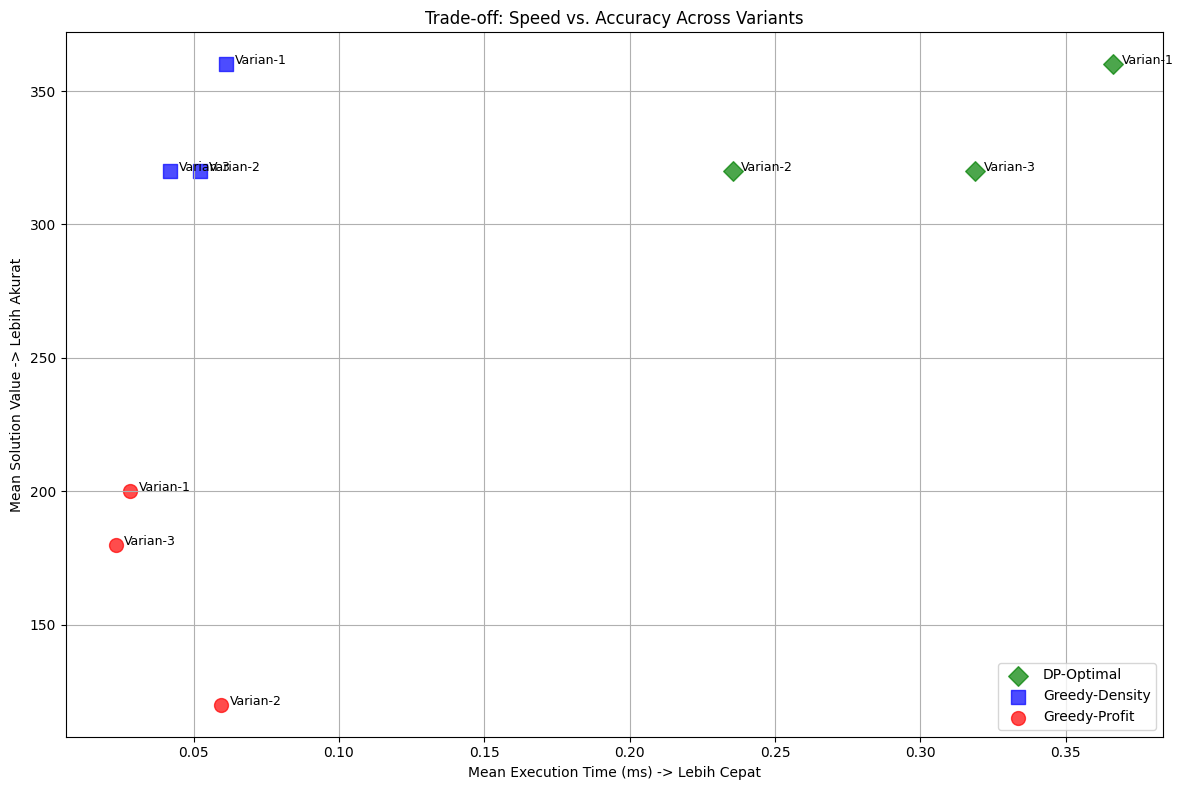

In [29]:
def visualize_trade_off(df_summary):
    plt.figure(figsize=(12, 8))

    colors = {'Greedy-Profit': 'red', 'Greedy-Density': 'blue', 'DP-Optimal': 'green'}
    markers = {'Greedy-Profit': 'o', 'Greedy-Density': 's', 'DP-Optimal': 'D'}

    for method in df_summary['method'].unique():
        data = df_summary[df_summary['method'] == method]

        # Plot scatter plot
        plt.scatter(
            data['time_ms_mean'],
            data['value'],
            label=method,
            color=colors[method],
            s=100,
            marker=markers[method],
            alpha=0.7
        )

        for i, row in data.iterrows():
            variant_label = row['variant'].split('-')[0] + '-' + row['variant'].split('-')[1].split(' ')[0]
            plt.text(
                row['time_ms_mean'] + 0.003,
                row['value'],
                variant_label,
                fontsize=9
            )

    plt.xlabel("Mean Execution Time (ms) -> Lebih Cepat")
    plt.ylabel("Mean Solution Value -> Lebih Akurat")
    plt.title("Trade-off: Speed vs. Accuracy Across Variants")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

visualize_trade_off(df_summary)

In [30]:
!pip install psutil

In [31]:
import psutil
import time

print(f"Jumlah inti (logical): {psutil.cpu_count(logical=True)}")

cpu_usage = psutil.cpu_percent(interval=1)
print(f"Penggunaan CPU saat ini: {cpu_usage}%")

Jumlah inti (logical): 2
Penggunaan CPU saat ini: 25.9%
